<a href="https://colab.research.google.com/github/mariang168/SU_MSADS/blob/main/Zip97212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
## SAMPLE TIME SERIES USING RETAIL DATA
## BASED ON MILLER (2015) and BROWNLEE (2016)

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
import seaborn as sns
import numpy as np

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('tab10', 8)))
dims = (11.7, 8.27)
%matplotlib inline

## Setting random seed
np.random.seed(1000)

In [44]:
Zip97212 = pd.read_csv("https://raw.githubusercontent.com/mariang168/SU_MSADS/main/IST718/Zip97212.csv").fillna(0)
#Zip94804 = pd.read_csv("Zip94804.csv").fillna(0)
#Zip98340 = pd.read_csv("Zip98340.csv").fillna(0)

In [47]:
#Zip97212
O_t = Zip97212.transpose()
O_t = pd.DataFrame(O_t)
O = O_t.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
#O = O.sort_index()
O.index.name = "Date"
O.index = pd.to_datetime(O.index)
O['Price']= O.mean(axis=1)
O

,0,Price
Date,,
1996-01-31,174011.3922,174011.3922
1996-02-29,175970.5486,175970.5486
1996-03-31,176822.8795,176822.8795
1996-04-30,178408.7697,178408.7697
1996-05-31,179482.0218,179482.0218
...,...,...
2022-02-28,860029.8453,860029.8453
2022-03-31,891040.3973,891040.3973
2022-04-30,913318.0658,913318.0658


In [46]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(O['Price'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.159279
p-value: 0.969883
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


ADF Statistic: -2.818251
p-value: 0.055714
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


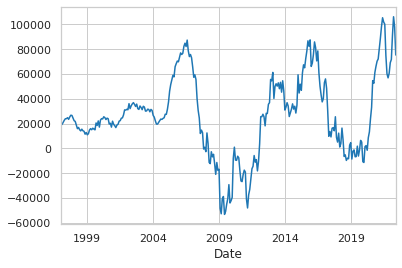

In [5]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

X = O['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = O.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()

In [6]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

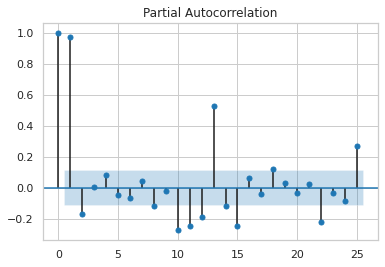

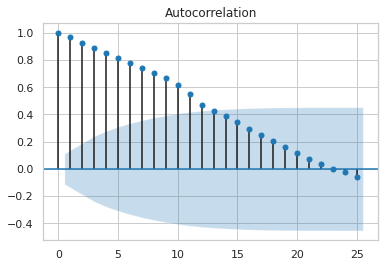

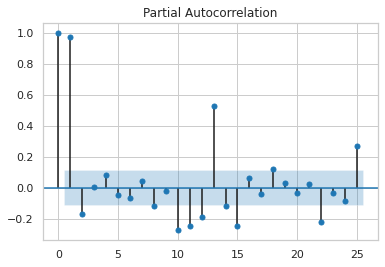

In [7]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)
plot_pacf(series)

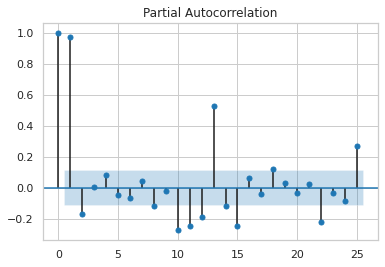

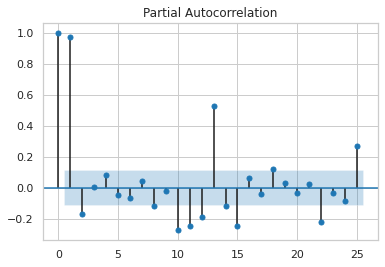

In [8]:
# USING STATIONARY TIME SERIES LOOK FOR PACF

plot_pacf(series)

In [9]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
#X = O['Price']
X = O['Price']
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=472545.364, Expected=490229
>Predicted=485555.708, Expected=490580
>Predicted=497925.880, Expected=484935
>Predicted=479797.873, Expected=483301
>Predicted=481279.757, Expected=486232
>Predicted=482235.193, Expected=486660
>Predicted=477614.980, Expected=488849
>Predicted=492541.969, Expected=477006
>Predicted=470808.458, Expected=474037
>Predicted=468906.278, Expected=470588
>Predicted=451839.426, Expected=483556
>Predicted=480119.266, Expected=487508
>Predicted=490783.917, Expected=480884
>Predicted=479348.140, Expected=481030
>Predicted=476334.923, Expected=478709
>Predicted=477387.002, Expected=475763
>Predicted=478258.593, Expected=468552
>Predicted=468270.323, Expected=460488
>Predicted=462919.400, Expected=462155
>Predicted=451158.709, Expected=456046
>Predicted=453723.541, Expected=456593
>Predicted=452864.227, Expected=451571
>Predicted=463965.507, Expected=442729
>Predicted=444533.205, Expected=439583
>Predicted=434843.386, Expected=443584
>Predicted=446268.788, Ex

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                  0
count    159.000000
mean     733.697414
std     9952.311833
min   -25266.730693
25%    -5379.474358
50%     2499.964951
75%     7405.940558
max    32881.327779
RMSE: 9948.059


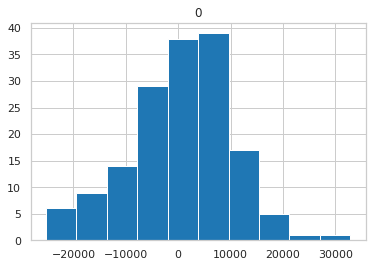

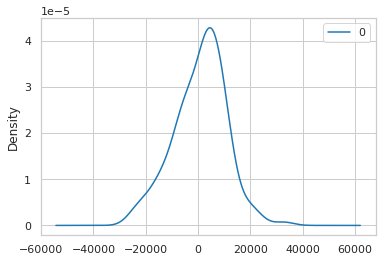

In [49]:
#Zip97212 ARIMA()
#@title
# SIMILAR BLOCK OF CODE - THIS ONE SAVES RESIDUALS FOR PLOTTING

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = O['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                  0
count    159.000000
mean     854.410501
std     9952.311833
min   -25146.017606
25%    -5258.761271
50%     2620.678038
75%     7526.653645
max    33002.040866
RMSE: 9957.690


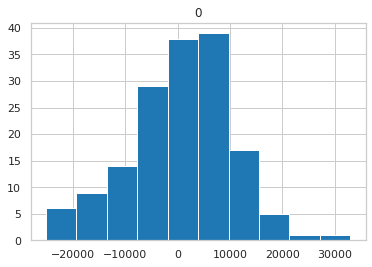

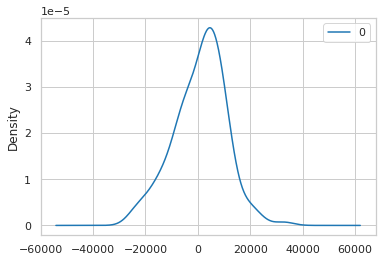

In [50]:
# MODEL - INTERPRET 
# RECREATE ANALYSIS WITH MEAN RESIDUAL ADDED TO EACH PREDICTION
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = O['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -120.713087
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

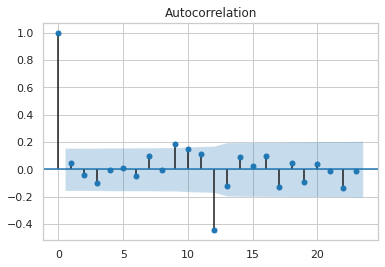

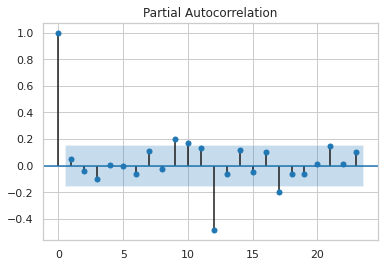

In [51]:
# INTERPRET -LOOK AT ACF AND PACF FOR RESIDUALS
# Ideally all residuals are not significant and mean==0
plot_acf(residuals, ax=plt.gca())
plt.show()

plot_pacf(residuals, ax=plt.gca())
plt.show()

In [52]:
# MODEL - CODE FROM BROWNLEE FOR SAVING MODEL
# NOTE:  This will save in your google drive UNLESS you specified a particular
# working directory
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = O['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(1,2,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [53]:
# MODEL
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = O['Price']
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 910195.001


In [54]:
#Pull Zip97212, Zip94804, Zip98340 file
from google.colab import files
uploaded = files.upload()

Saving O.csv to O (1).csv


In [55]:
# INTERPRET - CREATE TRAIN-TEST DATA
# DATA IS monthly from 1996 to 2021
# KEEP 2022 - 6 months - AS THE TEST DATA

series1 = pd.read_csv('O.csv', header=0,
                      index_col="Date", parse_dates=["Date"])
#series = O
split_point = len(series) - 6
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# STORES TO LOCAL DRIVE
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 312, Validation 6


>Predicted=910195.006, Expected=843412
>Predicted=833396.429, Expected=860030
>Predicted=855078.152, Expected=891040
>Predicted=885063.671, Expected=913318
>Predicted=924715.037, Expected=920066
>Predicted=923559.828, Expected=905069
RMSE: 35647.327


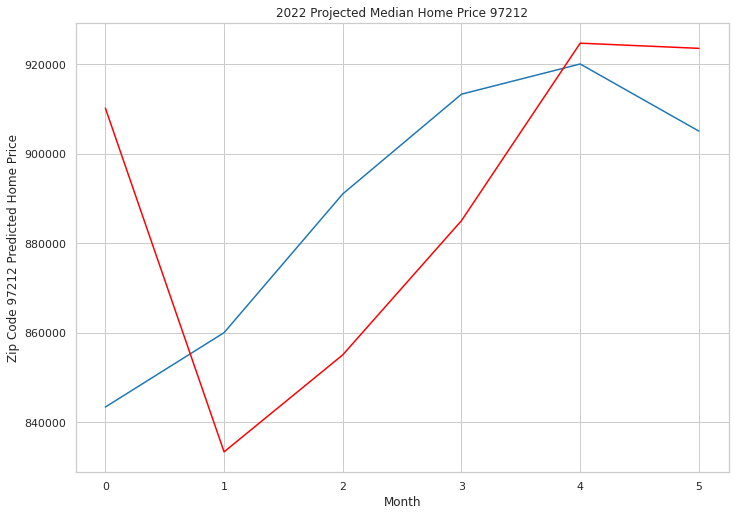

In [56]:
# MODEL & INTERPRET - 
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
# NEED VALIDATION FILE FROM ABOVE


def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = O['Price']
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
#validation = Series.from_csv('validation.csv', header=0)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
fig, ax = plt.subplots(figsize = dims)
plt.plot(y)
plt.plot(predictions, color='red')
plt.xlabel("Month")
plt.ylabel("Zip Code 97212 Predicted Home Price")
plt.title("2022 Projected Median Home Price 97212")
plt.show()

In [57]:
# timeseries data
ts_start = Zip97212.columns.get_loc('1996-01-31') + 1
ts_end = Zip97212.columns.get_loc('2022-06-30')
date_columns = Zip97212.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
Zip97212[date_columns] = Zip97212[date_columns].astype(int)

In [58]:
# train: collapse column by median
train_start = Zip97212.columns.get_loc('1996-01-31')
train_stop = Zip97212.columns.get_loc('2021-12-31')
test_stop = Zip97212.columns.get_loc('2022-06-30')
train_columns = Zip97212.iloc[:, train_start:train_stop].columns.tolist()
test_columns = Zip97212.iloc[:, (train_stop + 1):test_stop].columns.tolist()


In [59]:
# remove rows with 0's beginning (1997-01) with trainset
#date_columns = Zip97212.iloc[:, train_start:test_stop].columns.tolist()

Zip97212[date_columns] = Zip97212[date_columns].replace(0, np.nan)
Zip97212[date_columns] = Zip97212[date_columns].dropna()

In [60]:
# Creating training and testing datasets
df_train = Zip97212[train_columns].median().T
df_test = Zip97212[test_columns].median().T

In [61]:
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 10

for t in range(iterations):
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 12:
        year = 2022
        month = (t+ 2) % 12
        if month == 0:
            month = 12
    else:
        year = 2022
        month = t+ 2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)


date: 2022-2
-----------------------------------------------
predicted=831687.825334, expected=843412.000000
prediction difference: 0.013901

predicted=831687.825334

date: 2022-3
-----------------------------------------------
predicted=835386.927419, expected=860029.000000
prediction difference: 0.028653

predicted=835386.927419


/usr/local/lib/python3.7/dist-packages/statsmodels/base/data.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _endog = endog if hasattr(endog, 'ndim') else np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or


date: 2022-4
-----------------------------------------------
predicted=839088.244835, expected=891040.000000
prediction difference: 0.058305

predicted=839088.244835

date: 2022-5
-----------------------------------------------
predicted=842796.669360, expected=913318.000000
prediction difference: 0.077214

predicted=842796.669360

date: 2022-6
-----------------------------------------------
predicted=846511.419092, expected=920066.000000
prediction difference: 0.079945

Test MSE: 2765441465.018630




/usr/local/lib/python3.7/dist-packages/statsmodels/base/data.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _endog = endog if hasattr(endog, 'ndim') else np.asarray(endog)



date: 2022-7
-----------------------------------------------
predicted=936172.958313

date: 2022-8
-----------------------------------------------
predicted=948806.884313


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([np.diff(x, d - i)[0] for i in range(d, 0, -1)])



date: 2022-9
-----------------------------------------------
predicted=961273.123682

date: 2022-10
-----------------------------------------------
predicted=973761.729056

date: 2022-11
-----------------------------------------------
predicted=986285.227015

date: 2022-12
-----------------------------------------------
predicted=998843.243961

date: 2022-13
-----------------------------------------------
predicted=1011435.354292

date: 2022-14
-----------------------------------------------
predicted=1024061.665874

date: 2022-3
-----------------------------------------------
predicted=1036723.650413

date: 2022-4
-----------------------------------------------
predicted=1049419.929359

date: 2022-5
-----------------------------------------------
predicted=1062150.702433

date: 2022-6
-----------------------------------------------
predicted=1074916.368363


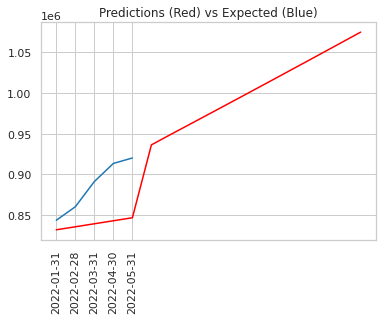

In [41]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(predictions, color='red')
    plt.plot(df_test)
    plt.xticks(rotation=90)
    plt.title('Predictions (Red) vs Expected (Blue)')
    plt.show()
rolling_plot(y, predictions)